In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [2]:
base_dir = 'results/generalist_final_1'
train_results_file = 'train_results.csv'
test_results_file = 'test_all_enemies_results.csv'
plots_dir = base_dir + '/plots'

## Train

In [3]:
# Read the single dataframes and merge them.

df_train_result = pd.read_csv(
    base_dir + '/' + train_results_file,
    delimiter=',', 
    header = 0)

In [4]:
# Success is defined as winning against the whole enemy_group
#
# Calculate metrics:
# - Average Evaluation on Success
# - Success rate
# - Mean Best Fitness
# These will be calculated for each (method, enemy_group) combination
n_train_runs = 10
population_size = 100
methods = df_train_result.method.unique()
enemy_groups = df_train_result.enemy_group.unique()
agg = df_train_result[['method', 'run', 'enemy_group', 'gen', 'individual_id', 'player_life']].groupby(['method', 'run', 'enemy_group', 'gen', 'individual_id'], as_index=False).min()
agg.rename(columns={'player_life': 'min_player_life'}, inplace=True)
success_solutions = agg[agg.min_player_life > 0]
first_success_gen = success_solutions[['method', 'run', 'enemy_group', 'gen']].groupby(['method', 'run', 'enemy_group'], as_index=False).min()
runs_with_success = first_success_gen[['method', 'enemy_group', 'run']].groupby(['method','enemy_group'], as_index=False).count()
sum_first_success_gen = first_success_gen[['method', 'enemy_group', 'gen']].groupby(['method', 'enemy_group'], as_index=False).sum()
aes_dict = {}
sr_dict = {}
for method in methods:
    for enemy_group in enemy_groups:
        num_runs_with_success_series = runs_with_success[
            (runs_with_success.method == method) & (runs_with_success.enemy_group == enemy_group)
        ]['run']
        num_runs_with_success = num_runs_with_success_series.tolist()[0] if len(num_runs_with_success_series) > 0 else 0
        num_runs_without_success = n_train_runs - num_runs_with_success
        sum_gens_to_sucess_series = sum_first_success_gen[
            (sum_first_success_gen.method == method) & (sum_first_success_gen.enemy_group == enemy_group)
        ]['gen']
        sum_gens_to_sucess = sum_gens_to_sucess_series.tolist()[0] if len(sum_gens_to_sucess_series) > 0 else 0
        total_gens_to_success = num_runs_without_success*100 + sum_gens_to_sucess
        average_generations_to_success = total_gens_to_success / n_train_runs
        aes = average_generations_to_success * population_size
        sr = num_runs_with_success / n_train_runs
        aes_dict[(method, enemy_group)] = aes
        sr_dict[(method, enemy_group)] = sr

best_fitness_per_run = df_train_result[df_train_result.gen == df_train_result.gen.max()][['method', 'run', 'enemy_group', 'avg_fitness']].groupby(['method', 'run', 'enemy_group'], as_index=False).max()
mbf_df = best_fitness_per_run[['method', 'enemy_group', 'avg_fitness']].groupby(['method', 'enemy_group'], as_index=False).mean()

mbf_dict = {}
for row in mbf_df.itertuples():
    mbf_dict[(row.method, row.enemy_group)] = row.avg_fitness
    
print("methods={}".format(methods))
print("enemy_groups={}".format(enemy_groups))
print("aes_dict={}".format(aes_dict))
print("sr_dict={}".format(sr_dict))
print("mbf_dict={}".format(mbf_dict))

methods=['EvomanGeneralist_GA' 'EvomanGeneralist_DE']
enemy_groups=['7_8' '3_7_8']
aes_dict={('EvomanGeneralist_GA', '7_8'): 409.99999999999994, ('EvomanGeneralist_GA', '3_7_8'): 9690.0, ('EvomanGeneralist_DE', '7_8'): 530.0, ('EvomanGeneralist_DE', '3_7_8'): 10000.0}
sr_dict={('EvomanGeneralist_GA', '7_8'): 1.0, ('EvomanGeneralist_GA', '3_7_8'): 0.2, ('EvomanGeneralist_DE', '7_8'): 1.0, ('EvomanGeneralist_DE', '3_7_8'): 0.0}
mbf_dict={('EvomanGeneralist_DE', '3_7_8'): 68.16289575857536, ('EvomanGeneralist_DE', '7_8'): 89.47170908007857, ('EvomanGeneralist_GA', '3_7_8'): 77.02375384102086, ('EvomanGeneralist_GA', '7_8'): 90.38357392442379}


In [31]:
def plot_feature_by_gen_with_std(df, feature, style=None):
    # Define the possible groups
    groups = df['enemy_group'].unique()

    fig, axes = plt.subplots(len(groups),1, figsize=(10, 8))
    fig.suptitle('Training statistics', fontsize=22)

    if len(groups) > 1: 

        for idx, enemy_group in enumerate(groups):
            sns.lineplot(ax=axes[idx],
                        data=df[df['enemy_group'] == enemy_group],
                        x="gen",
                        y=feature,
                        hue="method",
                        style=style,
                        ci='sd')

            axes[idx].set_title('Group: ' + str(enemy_group), fontsize=16)
            axes[idx].set_xlabel('Generation', fontsize=14)
            axes[idx].set_ylabel(feature, fontsize=14)
            
        # Remove single legend
        for ax in axes:
            ax.get_legend().remove()
    
    else:
        sns.lineplot(ax=axes,
                        data=df[df['enemy_group'] == groups[0]],
                        x="gen",
                        y=feature,
                        hue="method",
                        style=style,
                        ci='sd')

        axes.set_title('Group: ' + str(groups[0]), fontsize=16)
        axes.set_xlabel('Generation', fontsize=14)
        axes.set_ylabel(feature, fontsize=14)        

    plt.legend(fontsize='x-large', title_fontsize='40')
    plt.tight_layout()
    plt.savefig(plots_dir + '/lineplot_' + feature)

In [32]:
def plot_max_avg_by_gen(df):
    # Max an avg plots
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)

    # Aggregate individuals
    df_aggregated = df.groupby(['method', 'enemy_group', 'run', 'gen', 'individual_id']).mean().reset_index()

    # Creation of the max avg df
    df_mean = df_aggregated.groupby(['method', 'enemy_group', 'run', 'gen']).mean().reset_index().loc[:,['method', 'enemy_group' ,'run', 'gen', 'avg_fitness']]
    df_mean['stat'] = 'mean'
    df_max = df_aggregated.groupby(['method', 'enemy_group', 'run' ,'gen']).max().reset_index().loc[:,['method', 'enemy_group' ,'run', 'gen', 'avg_fitness']]
    df_max['stat'] = 'max'

    df_mean_max = pd.concat([df_mean, df_max]).reset_index(drop=True)
    plot_feature_by_gen_with_std(df=df_mean_max, feature='avg_fitness', style='stat')

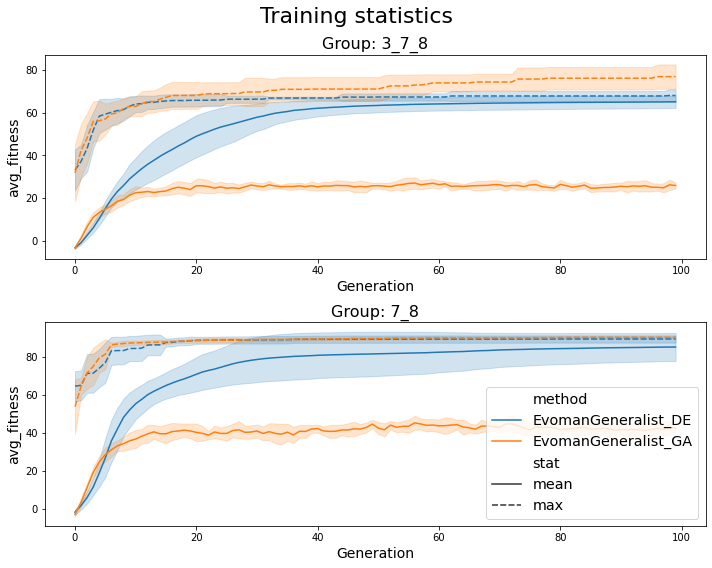

In [33]:
# Plot the avg and the max
plot_max_avg_by_gen(df_train_result)


# Other plots that one can check
#plot_win_ratio(df)
#plot_feature_by_gen_with_std(df=df[df['method'] == 'EvomanGeneralist1']  , feature='player_life_importance')
#plot_feature_by_gen_with_std(df=df, feature='custom_fitness', style='method', style='stat')

## Test

In [3]:
# Read the single dataframes and merge them.
df_test_result = pd.read_csv(
    base_dir + '/' + test_results_file,
    delimiter=',', 
    header = 0,
    )

# Create the individual gain for each enemy
df_test_result['gain'] = df_test_result['player_life'] - df_test_result['enemy_life']

In [4]:
def plot_boxes_test(df, plots_dir):
    plt.figure(figsize=(10, 5))

    # Aggregate rows anc creating the mean of the gain from enemy1 to enemy9
    df_test_grouped = df.groupby(['method', 'enemy_group', 'run']).mean().reset_index()
    ax = sns.boxplot(x="enemy_group", y="gain", hue="method", data=df_test_grouped)
    ax = sns.swarmplot(x="enemy_group", y="gain", hue="method", data=df_test_grouped, color='0.25',dodge=True)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(fontsize='x-large', title_fontsize='40')
    ax.legend(handles[0:2], labels[0:2])

    plt.title('Gain for test dataset', fontsize=22)
    plt.xlabel('Enemy group', fontsize=18)
    plt.ylabel('Gain value', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(plots_dir + '/box_plot_all_enemies')

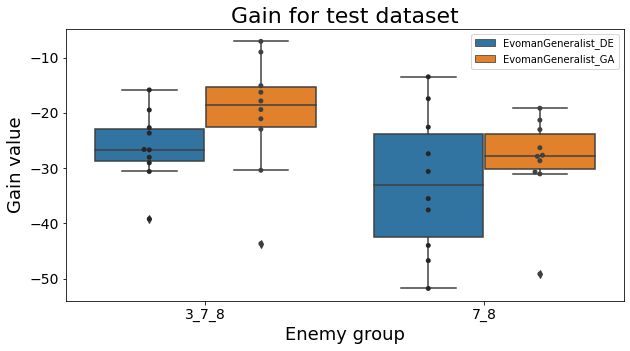

In [5]:
plot_boxes_test(df_test_result, plots_dir)

In [27]:
df_test_result['win'] = df_test_result.enemy_life.apply(lambda x: 1 if x == 0 else 0)
df_test_result['rounds'] = 1
df_test_result.groupby(['method', 'enemy_group', 'enemy']).sum().reset_index().loc[:,('method', 'enemy_group', 'enemy', 'win', 'rounds')]

,method,enemy_group,enemy,win,rounds
0,EvomanGeneralist_DE,3_7_8,1,0,100
1,EvomanGeneralist_DE,3_7_8,2,81,100
2,EvomanGeneralist_DE,3_7_8,3,2,100
3,EvomanGeneralist_DE,3_7_8,4,0,100
4,EvomanGeneralist_DE,3_7_8,5,87,100
5,EvomanGeneralist_DE,3_7_8,6,0,100
6,EvomanGeneralist_DE,3_7_8,7,18,100
7,EvomanGeneralist_DE,3_7_8,8,26,100
8,EvomanGeneralist_DE,7_8,1,0,100
9,EvomanGeneralist_DE,7_8,2,59,100


In [12]:
# Find best solutions player avg energy an enemy energy
df_test_result.loc[
    (df_test_result.method == 'EvomanGeneralist_GA') &
    (df_test_result.enemy_group == '3_7_8') &
    (df_test_result.run == 3)
    ,:
].groupby(['method', 'run', 'enemy_group', 'enemy']).mean().reset_index()

,method,run,enemy_group,enemy,test_run,fitness,player_life,enemy_life,time,avg_fitness,gain
0,EvomanGeneralist_GA,3,3_7_8,1,4.5,22.058477,0.00,70.0,141.6,24.114695,-70.00
1,EvomanGeneralist_GA,3,3_7_8,2,4.5,92.335150,78.60,0.0,252.2,24.114695,78.60
2,EvomanGeneralist_GA,3,3_7_8,3,4.5,76.870582,7.00,9.0,312.6,24.114695,-2.00
3,EvomanGeneralist_GA,3,3_7_8,4,4.5,30.303440,0.00,60.0,297.9,24.114695,-60.00
4,EvomanGeneralist_GA,3,3_7_8,5,4.5,89.877907,55.24,0.0,284.5,24.114695,55.24
5,EvomanGeneralist_GA,3,3_7_8,6,4.5,3.333792,0.00,91.0,117.8,24.114695,-91.00
6,EvomanGeneralist_GA,3,3_7_8,7,4.5,81.622682,11.90,4.0,392.1,24.114695,7.90
7,EvomanGeneralist_GA,3,3_7_8,8,4.5,84.684770,9.16,0.0,509.4,24.114695,9.16


In [13]:
# Find best solutions player std energy an enemy energy
df_test_result.loc[
    (df_test_result.method == 'EvomanGeneralist_GA') &
    (df_test_result.enemy_group == '3_7_8') &
    (df_test_result.run == 3)
    ,:
].groupby(['method', 'run', 'enemy_group', 'enemy']).std().reset_index()

,method,run,enemy_group,enemy,test_run,fitness,player_life,enemy_life,time,avg_fitness,gain
0,EvomanGeneralist_GA,3,3_7_8,1,3.02765,7.208795,0.000000,8.164966,23.566455,2.977908,8.164966
1,EvomanGeneralist_GA,3,3_7_8,2,3.02765,0.459151,3.657564,0.000000,27.875916,2.977908,3.657564
2,EvomanGeneralist_GA,3,3_7_8,3,3.02765,14.236222,13.207742,15.238839,59.404826,2.977908,23.380904
3,EvomanGeneralist_GA,3,3_7_8,4,3.02765,0.020900,0.000000,0.000000,6.279597,2.977908,0.000000
4,EvomanGeneralist_GA,3,3_7_8,5,3.02765,0.515116,4.419955,0.000000,30.952473,2.977908,4.419955
5,EvomanGeneralist_GA,3,3_7_8,6,3.02765,2.893004,0.000000,3.162278,9.223159,2.977908,3.162278
6,EvomanGeneralist_GA,3,3_7_8,7,3.02765,8.487057,19.200289,8.432740,35.955065,2.977908,23.356798
7,EvomanGeneralist_GA,3,3_7_8,8,3.02765,0.523184,4.553680,0.000000,32.887688,2.977908,4.553680
